# LIBRARIES
 ## (Download libraries needed for the Analyzer)

In [2]:
# Data Processing Librearies 
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xlrd
import time
import pandas as pd
import operator
import glob, os, shutil
from numpy import math


# Data Processing Librearies 
from datetime import datetime, timedelta, date
import numpy as np
import matplotlib.pyplot as plt
import xlrd
import time
import pandas as pd


#Machine learning
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

#Server EMail
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
import os.path


from tkinter import filedialog
from tkinter import *
root = Tk()


# Extract & load information

In [5]:
# Get today´s date in format: dd/mm/YY
today = date.today()
TodayDate = today.strftime("%d_%m_%Y")



# File directory
root.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select file",filetypes=[("Excel files", "*.xlsx; *.xls")])
FileDirectory = root.filename

# Base_line: read
BaseLine = pd.read_excel(FileDirectory,index_col=0).reset_index()

#Renombrar columnas de archivo virgen para ser proecesado en horas
BaseLine.rename(columns={"Unidad Energía":"FECHA",'KWh':'H0','Unnamed: 2':'H1','Unnamed: 3':'H2','Unnamed: 4':'H3','Unnamed: 5':'H4','Unnamed: 6':'H5','Unnamed: 7':'H6','Unnamed: 8':'H7','Unnamed: 9':'H8','Unnamed: 10':'H9','Unnamed: 11':'H10','Unnamed: 12':'H11','Unnamed: 13':'H12','Unnamed: 14':'H13','Unnamed: 15':'H14','Unnamed: 16':'H15','Unnamed: 17':'H16','Unnamed: 18':'H17','Unnamed: 19':'H18','Unnamed: 20':'H19','Unnamed: 21':'H20','Unnamed: 22':'H21','Unnamed: 23':'H22','Unnamed: 24':'H23','Unnamed: 25':'TOTAL'}, inplace=True)

#Base line: Columns selection  
BaseLine = BaseLine[['FECHA','H0','H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23']]
#Base line: Last 105 days of measurements
BaseLine = BaseLine.iloc[len(BaseLine['FECHA'])-61:len(BaseLine['FECHA'])-1].reset_index()
#Reemplazar los valores NaN porceros.
BaseLine = BaseLine.fillna(0)

#________________________________________________
#Preparación de datos

HolidayList =   [['2019-01-01'], ['2019-01-07'], ['2019-03-25'], ['2019-04-18'], ['2019-04-19'], ['2019-05-01'], ['2019-06-03'], ['2019-06-24'],
 ['2019-07-01'], ['2019-07-20'], ['2019-08-07'], ['2019-08-19'], ['2019-10-14'], ['2019-11-11'], ['2019-12-08'], ['2019-12-25'],
 ['2020-01-01'], ['2020-01-06'], ['2020-03-23'], ['2020-04-09'], ['2020-04-10'], ['2020-05-01'], ['2020-05-25'], ['2020-06-15'], 
 ['2020-06-22'], ['2020-06-29'], ['2020-07-20'], ['2020-08-07'], ['2020-08-17'], ['2020-10-12'], ['2020-11-02'], ['2020-11-16'],
 ['2020-12-08'], ['2020-11-25'], ['2021-01-01'], ['2021-01-11'], ['2021-03-22'], ['2021-04-01'], ['2021-04-02'], ['2021-05-01'],
 ['2021-05-17'], ['2021-06-07'], ['2021-06-14'], ['2021-07-05'], ['2021-07-20'], ['2021-08-07'], ['2021-08-18'], ['2021-11-01'],
 ['2021-11-15'], ['2021-12-08'], ['2021-12-25'], ['2022-01-01'], ['2022-01-10'], ['2022-03-21'], ['2022-04-14'], ['2022-04-15'],
 ['2022-05-01'], ['2022-05-17'], ['2022-06-20'], ['2022-06-27'], ['2022-07-04'], ['2022-07-20'], ['2022-08-07'], ['2022-08-15'],
 ['2022-10-17'], ['2022-11-07'], ['2022-11-14'], ['2022-12-08'], ['2022-12-25'], ['2023-01-01'], ['2023-01-09'], ['2023-03-20'],
 ['2023-04-02'], ['2023-04-06'], ['2023-04-07'], ['2023-04-09'], ['2023-05-01'], ['2023-05-22'], ['2023-06-12'], ['2023-06-19'],
 ['2023-07-03'], ['2023-07-20'], ['2023-08-07'], ['2023-08-21'], ['2023-10-16'], ['2023-11-06'], ['2023-11-13'], ['2023-12-08'], 
 ['2023-12-25']]

HolidayList = pd.DataFrame (HolidayList, columns = ['Holidays'])

#________________________________________________
#1. Preparación de datos

#1.1 Sumar consumo diario (Ct)
#Base line: Daily consuption
BaseLine['TOTAL'] = round(BaseLine['H0'] + BaseLine['H1'] + BaseLine['H2'] + BaseLine['H3'] + BaseLine['H4'] + BaseLine['H5'] + BaseLine['H6'] + BaseLine['H7'] + BaseLine['H8'] + BaseLine['H9'] + BaseLine['H10'] + BaseLine['H11'] + BaseLine['H12'] + BaseLine['H13'] + BaseLine['H14'] + BaseLine['H15'] + BaseLine['H16'] + BaseLine['H17'] + BaseLine['H18'] + BaseLine['H19'] + BaseLine['H20'] + BaseLine['H21'] + BaseLine['H22'] + BaseLine['H23'],2) 

#1.2 Identificar qué día de la semana es cada fecha y procesa los festivos
# Base line: Days convertion/correction
BaseLine['WEEKDAY']  = pd.Series([0 for x in range(len(BaseLine['FECHA']))])
BaseLine['FESTIVOS'] = pd.Series([0 for x in range(len(BaseLine['FECHA']))])

#Asigna a cada fecha el día de la semana correspondiente
for MeasuredDays in range(len(BaseLine['FECHA'])):
    BaseLine['WEEKDAY'].iloc[MeasuredDays] = datetime.strptime(BaseLine['FECHA'].iloc[MeasuredDays], '%Y-%m-%d').weekday() + 1

    
#Identificar si el día es festivo y marcarlo como tal con la categoría del día 8 
for MeasuredDays in range(len(BaseLine['FECHA'])):
    if BaseLine['FECHA'][MeasuredDays] in list(HolidayList['Holidays']):
        BaseLine['FESTIVOS'][MeasuredDays] = 1 #Identifica en una columna llamada FESTIVOS los días festivos
        BaseLine['WEEKDAY'][MeasuredDays] = 8 #Asigna como día 8 a todos los festivos.

#________________________________________________
#2.Limpiar datos cero y desviados

#Reducción de datos para mayor velocidad
BaseLine_summary    = BaseLine[['FECHA','FESTIVOS','WEEKDAY','TOTAL']]

#2.1 Reemplazo datos cero
for MeasuredDays in range(len(BaseLine_summary['FECHA'])):
    if BaseLine_summary['TOTAL'][MeasuredDays] == 0:
        #A qué día pertenece ese valor cero
        DayOfTheWeek = BaseLine_summary['WEEKDAY'][MeasuredDays]

        #Toma todos los datos de la BL con el mismo día identificado en el paso anterior
        AllDaysInBaseLine = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == DayOfTheWeek]
        AllDaysInBaseLine = AllDaysInBaseLine.reset_index()
        MeasuredDays = list(AllDaysInBaseLine['index']).index(MeasuredDays)
        
        #Calcula el valor promedio de los 5 días previos o en su defecto en los días previos disponibles
        #ReplacingAverageValue = round(AllDaysInBaseLine.loc[MeasuredDays-5:MeasuredDays-1, 'TOTAL'].mean(axis=0))
        
        if math.isnan(AllDaysInBaseLine.loc[MeasuredDays-5:MeasuredDays-1, 'TOTAL'].mean(axis=0)):
            ReplacingAverageValue = AllDaysInBaseLine['TOTAL'].mean(axis=0)
        else:
            ReplacingAverageValue = AllDaysInBaseLine.loc[MeasuredDays-5:MeasuredDays-1, 'TOTAL'].mean(axis=0)
        
        #Al día con consumo cero se le reemplaza por el promedio calculado en paso anterior
        BaseLine_summary['TOTAL'][MeasuredDays] = ReplacingAverageValue
        

#2.2 Subgrupo del dataset dividido por día de la semana
BaseLine_Mondays     = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == 1]
BaseLine_Tuesdays    = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == 2]
BaseLine_Wednesdays  = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == 3]
BaseLine_Thursdays   = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == 4]
BaseLine_Fridays     = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == 5]
BaseLine_Saturdays   = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == 6]
BaseLine_Sundays     = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == 7]
BaseLine_Holidays    = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == 8]


C:\Users\luisp\AppData\Local\Temp/ipykernel_15328/754462730.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BaseLine['FESTIVOS'][MeasuredDays] = 1 #Identifica en una columna llamada FESTIVOS los días festivos
C:\Users\luisp\AppData\Local\Temp/ipykernel_15328/754462730.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BaseLine['WEEKDAY'][MeasuredDays] = 8 #Asigna como día 8 a todos los festivos.


In [7]:
BaseLine_Holidays

,FECHA,FESTIVOS,WEEKDAY,TOTAL
29,2021-11-01,1,8,49216.49
43,2021-11-15,1,8,45028.49


In [4]:

#2.3 Corrección de datos atípicos
#Cálculo de percentiles, rangos y limites admisibles de datos por día

AtypicalDataCorrectionIndex = pd.DataFrame(np.zeros((7, 6)))
AtypicalDataCorrectionIndex.rename(columns={0:'WEEKDAY',1:'Percentil_1',2:'Percentil_3',3:'Range',4:'LowerLimit',5:'UpperLimit'}, inplace=True)

for i in range(0,7,1):
    AtypicalDataCorrectionIndex['WEEKDAY'].iloc[i] = i + 1
    DataAnalyzedDay = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == i + 1]
    AtypicalDataCorrectionIndex['Percentil_1'].iloc[i] = round(np.percentile(DataAnalyzedDay['TOTAL'], 25))
    AtypicalDataCorrectionIndex['Percentil_3'].iloc[i] = round(np.percentile(DataAnalyzedDay['TOTAL'], 75))

AtypicalDataCorrectionIndex['Range'] = AtypicalDataCorrectionIndex['Percentil_3'] - AtypicalDataCorrectionIndex['Percentil_1']
AtypicalDataCorrectionIndex['LowerLimit'] = AtypicalDataCorrectionIndex['Percentil_1'] - 1.5*AtypicalDataCorrectionIndex['Range']
AtypicalDataCorrectionIndex['UpperLimit'] = AtypicalDataCorrectionIndex['Percentil_3'] + 1.5*AtypicalDataCorrectionIndex['Range']



for MeasuredDays in range(len(BaseLine_summary['FECHA'])):
    Day = BaseLine_summary['WEEKDAY'].iloc[MeasuredDays]
    UpperLimit = AtypicalDataCorrectionIndex['UpperLimit'].iloc[Day-1]
    Lowerlimit = AtypicalDataCorrectionIndex['LowerLimit'].iloc[Day-1]
    
    if (UpperLimit <= BaseLine_summary['TOTAL'].iloc[MeasuredDays]):

        #A qué día pertenece ese valor atípico
        DayOfTheWeek = BaseLine_summary['WEEKDAY'][MeasuredDays]
        
        #Toma todos los datos de la BL con el mismo día identificado en el paso anterior
        AllDaysInBaseLine = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == DayOfTheWeek]
        AllDaysInBaseLine = AllDaysInBaseLine.reset_index()
        DayInBaseLine = list(AllDaysInBaseLine['index']).index(MeasuredDays)

        
        #Calcula el valor promedio de los 5 días previos o en su defecto en los días previos disponibles
        #ReplacingAverageValue = round(AllDaysInBaseLine.loc[MeasuredDays-5:MeasuredDays-1, 'TOTAL'].mean(axis=0))
        if math.isnan(AllDaysInBaseLine.loc[DayInBaseLine-5:DayInBaseLine-1,'TOTAL'].mean(axis=0)):
            ReplacingAverageValue = AllDaysInBaseLine['TOTAL'].mean(axis=0)
        else:
            ReplacingAverageValue = AllDaysInBaseLine.loc[DayInBaseLine-5:DayInBaseLine-1, 'TOTAL'].mean(axis=0)
        
        #Al día con consumo atípico se le reemplaza por el promedio calculado en paso anterior
        BaseLine_summary['TOTAL'][MeasuredDays] = ReplacingAverageValue

        
    if (BaseLine_summary['TOTAL'].iloc[MeasuredDays] <= Lowerlimit):

        #A qué día pertenece ese valor atípico
        DayOfTheWeek = BaseLine_summary['WEEKDAY'][MeasuredDays]
        
        #Toma todos los datos de la BL con el mismo día identificado en el paso anterior
        AllDaysInBaseLine = BaseLine_summary.loc[BaseLine_summary['WEEKDAY'] == DayOfTheWeek]
        AllDaysInBaseLine = AllDaysInBaseLine.reset_index()
        DayInBaseLine = list(AllDaysInBaseLine['index']).index(MeasuredDays)
        
        #Calcula el valor promedio de los 5 días previos o en su defecto en los días previos disponibles
        #ReplacingAverageValue = round(AllDaysInBaseLine.loc[MeasuredDays-5:MeasuredDays-1, 'TOTAL'].mean(axis=0))
        if math.isnan(AllDaysInBaseLine.loc[DayInBaseLine-5:DayInBaseLine-1,'TOTAL'].mean(axis=0)):
            ReplacingAverageValue = AllDaysInBaseLine['TOTAL'].mean(axis=0)
        else:
            ReplacingAverageValue = AllDaysInBaseLine.loc[DayInBaseLine-5:DayInBaseLine-1,'TOTAL'].mean(axis=0)
            
        #Al día con consumo atípico se le reemplaza por el promedio calculado en paso anterior
        BaseLine_summary['TOTAL'][MeasuredDays] = ReplacingAverageValue            

        
        
        
#Determinar último día calculado
#ESTO SIRVE PARA PODER PRONOSTICAR LOS DÍAS QUE PIDE XM EN SU TABLA
RealLastDayMeasured = BaseLine_summary['WEEKDAY'].iloc[MeasuredDays]






#_______________________________________________________
#3 PREPARACIÓN DE DATOS PARA DASHBOARD


#Se lee nuevamente el archivo fuente y se ignoran festivos, con el ánimo de entender
#El comportamiento por día de los clientes


# File directory
FileDirectory = root.filename

# Base_line: read
BaseLine = pd.read_excel(FileDirectory,index_col=0).reset_index()

#Renombrar columnas de archivo virgen para ser proecesado en horas
BaseLine.rename(columns={"Unidad Energía":"FECHA",'KWh':'H0','Unnamed: 2':'H1','Unnamed: 3':'H2','Unnamed: 4':'H3','Unnamed: 5':'H4','Unnamed: 6':'H5','Unnamed: 7':'H6','Unnamed: 8':'H7','Unnamed: 9':'H8','Unnamed: 10':'H9','Unnamed: 11':'H10','Unnamed: 12':'H11','Unnamed: 13':'H12','Unnamed: 14':'H13','Unnamed: 15':'H14','Unnamed: 16':'H15','Unnamed: 17':'H16','Unnamed: 18':'H17','Unnamed: 19':'H18','Unnamed: 20':'H19','Unnamed: 21':'H20','Unnamed: 22':'H21','Unnamed: 23':'H22','Unnamed: 24':'H23','Unnamed: 25':'TOTAL'}, inplace=True)

#Base line: Columns selection  
BaseLine = BaseLine[['FECHA','H0','H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11','H12','H13','H14','H15','H16','H17','H18','H19','H20','H21','H22','H23','TOTAL']]
#Base line: Last 105 days of measurements
BaseLine = BaseLine.iloc[len(BaseLine['FECHA'])-106:len(BaseLine['FECHA'])-1].reset_index()
#Reemplazar los valores NaN porceros.
BaseLine = BaseLine.fillna(0)






#1.2 Identificar qué día de la semana es cada fecha y procesa los festivos
# Base line: Days convertion/correction
BaseLine['WEEKDAY'] = pd.Series([0 for x in range(len(BaseLine['FECHA']))])

#Asigna a cada fecha, el día de la semana correspondiente
for MeasuredDays in range(len(BaseLine['FECHA'])):
    BaseLine['WEEKDAY'].iloc[MeasuredDays] = datetime.strptime(BaseLine['FECHA'].iloc[MeasuredDays], '%Y-%m-%d').weekday() + 1



BaseLine_Mondays    = BaseLine.loc[BaseLine['WEEKDAY'] == 1]
BaseLine_Tuesdays   = BaseLine.loc[BaseLine['WEEKDAY'] == 2]
BaseLine_Wednesdays = BaseLine.loc[BaseLine['WEEKDAY'] == 3]
BaseLine_Thursdays  = BaseLine.loc[BaseLine['WEEKDAY'] == 4]
BaseLine_Fridays    = BaseLine.loc[BaseLine['WEEKDAY'] == 5]
BaseLine_Saturdays  = BaseLine.loc[BaseLine['WEEKDAY'] == 6]
BaseLine_Sundays    = BaseLine.loc[BaseLine['WEEKDAY'] == 7]


#3.1 Sacar promedios simples por días
#Saca la energía promedio  por día de la semana 
SimpleAverage_summary   = BaseLine_summary[['TOTAL']].mean(axis=0)
SimpleAverage_Monday    = BaseLine_Mondays[['TOTAL']].mean(axis=0)
SimpleAverage_Tuesday   = BaseLine_Tuesdays[['TOTAL']].mean(axis=0)
SimpleAverage_Wednesday = BaseLine_Wednesdays[['TOTAL']].mean(axis=0)
SimpleAverage_Thursday  = BaseLine_Thursdays[['TOTAL']].mean(axis=0)
SimpleAverage_Friday    = BaseLine_Fridays[['TOTAL']].mean(axis=0)
SimpleAverage_Saturday  = BaseLine_Saturdays[['TOTAL']].mean(axis=0)
SimpleAverage_Sunday    = BaseLine_Sundays[['TOTAL']].mean(axis=0)

#3.2 Base line: Average base line by days of the week
#Saca la CURVA promedio de energía por día de la semana.
Curve_Average_week      = BaseLine_summary.mean(axis=0)
Curve_Average_Monday    = BaseLine_Mondays.mean(axis=0)
Curve_Average_Tuesday   = BaseLine_Tuesdays.mean(axis=0)
Curve_Average_Wednesday = BaseLine_Wednesdays.mean(axis=0)
Curve_Average_Thursday  = BaseLine_Thursdays.mean(axis=0)
Curve_Average_Friday    = BaseLine_Fridays.mean(axis=0)
Curve_Average_Saturday  = BaseLine_Saturdays.mean(axis=0)
Curve_Average_Sunday    = BaseLine_Sundays.mean(axis=0)



C:\Users\luisp\AppData\Local\Temp/ipykernel_15328/2564342511.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BaseLine_summary['TOTAL'][MeasuredDays] = ReplacingAverageValue


IndexError: single positional indexer is out-of-bounds

# Information proccesing
## Maths

m: 
 [[3.98070569]]
b: 
 [3668.1743305]
Mean squared error: 428541.27
Variance score: 0.03


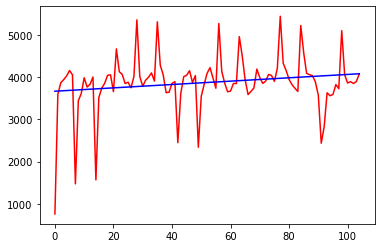

MAPE: 14.827305546110761 %
           Cnk          Tnk        Ek  Day
0  2663.911054  4062.264194  0.655770  7.0
1  3986.328452  4066.244899  0.980346  1.0
2  4403.502775  4070.225605  1.081882  2.0
3  4403.764989  4074.206311  1.080889  3.0
4  4419.688044  4078.187016  1.083738  4.0
5  4526.182019  4082.167722  1.108769  5.0
6  4121.310257  4086.148428  1.008605  6.0


In [3]:
#5.Calcular promedio móvil (PMt), indicies preliminares y indices ajustados
Indices = pd.DataFrame(np.zeros((99, 5)))
Indices.rename(columns={0:'WEEKDAY',1:'Ct',2:'PMt',3:'Ct/PMt',4:'Dt'}, inplace=True)

for MeasuredDays in range(0,99, 1):
    Indices['WEEKDAY'].iloc[MeasuredDays] = BaseLine_summary['WEEKDAY'].iloc[MeasuredDays+3] 
    Indices['Ct'].iloc[MeasuredDays]      = BaseLine_summary['TOTAL'].iloc[MeasuredDays+3]
    Indices['PMt'].iloc[MeasuredDays]     = (BaseLine_summary['TOTAL'].iloc[MeasuredDays] + BaseLine_summary['TOTAL'].iloc[MeasuredDays+1] + BaseLine_summary['TOTAL'].iloc[MeasuredDays+2] + BaseLine_summary['TOTAL'].iloc[MeasuredDays+3] + BaseLine_summary['TOTAL'].iloc[MeasuredDays+4] + BaseLine_summary['TOTAL'].iloc[MeasuredDays+5] + BaseLine_summary['TOTAL'].iloc[MeasuredDays+6])/7       
    Indices['Ct/PMt'].iloc[MeasuredDays]  = Indices['Ct'].iloc[MeasuredDays] / Indices['PMt'].iloc[MeasuredDays]

#6.Calcular indices preliminares (~Ei)
Prelimiar_E1 = Indices.loc[Indices['WEEKDAY'] == 1]['Ct/PMt'].mean(axis=0)
Prelimiar_E2 = Indices.loc[Indices['WEEKDAY'] == 2]['Ct/PMt'].mean(axis=0)
Prelimiar_E3 = Indices.loc[Indices['WEEKDAY'] == 3]['Ct/PMt'].mean(axis=0)
Prelimiar_E4 = Indices.loc[Indices['WEEKDAY'] == 4]['Ct/PMt'].mean(axis=0)
Prelimiar_E5 = Indices.loc[Indices['WEEKDAY'] == 5]['Ct/PMt'].mean(axis=0)
Prelimiar_E6 = Indices.loc[Indices['WEEKDAY'] == 6]['Ct/PMt'].mean(axis=0)
Prelimiar_E7 = Indices.loc[Indices['WEEKDAY'] == 7]['Ct/PMt'].mean(axis=0)

#print(Prelimiar_E1,Prelimiar_E2,Prelimiar_E3,Prelimiar_E4,Prelimiar_E5,Prelimiar_E6,Prelimiar_E7)

#7.Ajustar indices preliminares (Ei)
Ajustado_E1 = 7*Prelimiar_E1*(1/(Prelimiar_E1+Prelimiar_E2+Prelimiar_E3+Prelimiar_E4+Prelimiar_E5+Prelimiar_E6+Prelimiar_E7))
Ajustado_E2 = 7*Prelimiar_E2*(1/(Prelimiar_E1+Prelimiar_E2+Prelimiar_E3+Prelimiar_E4+Prelimiar_E5+Prelimiar_E6+Prelimiar_E7))
Ajustado_E3 = 7*Prelimiar_E3*(1/(Prelimiar_E1+Prelimiar_E2+Prelimiar_E3+Prelimiar_E4+Prelimiar_E5+Prelimiar_E6+Prelimiar_E7))
Ajustado_E4 = 7*Prelimiar_E4*(1/(Prelimiar_E1+Prelimiar_E2+Prelimiar_E3+Prelimiar_E4+Prelimiar_E5+Prelimiar_E6+Prelimiar_E7))
Ajustado_E5 = 7*Prelimiar_E5*(1/(Prelimiar_E1+Prelimiar_E2+Prelimiar_E3+Prelimiar_E4+Prelimiar_E5+Prelimiar_E6+Prelimiar_E7))
Ajustado_E6 = 7*Prelimiar_E6*(1/(Prelimiar_E1+Prelimiar_E2+Prelimiar_E3+Prelimiar_E4+Prelimiar_E5+Prelimiar_E6+Prelimiar_E7))
Ajustado_E7 = 7*Prelimiar_E7*(1/(Prelimiar_E1+Prelimiar_E2+Prelimiar_E3+Prelimiar_E4+Prelimiar_E5+Prelimiar_E6+Prelimiar_E7))

#print(Ajustado_E1,Ajustado_E2,Ajustado_E3,Ajustado_E4,Ajustado_E5,Ajustado_E6,Ajustado_E7)

#8.Estimación de tendencia (Desestacionalizar los datos dividiendo C entre su índice estacional E) Dt= Ct/Et
Dt = pd.DataFrame(np.zeros((105,1)))
Dt.rename(columns={0:'Dt'}, inplace=True)

for MeasuredDays in range(0,105,1):
    if BaseLine_summary['WEEKDAY'].iloc[MeasuredDays] == 1:
        Dt['Dt'].iloc[MeasuredDays] =  (BaseLine_summary['TOTAL'].iloc[MeasuredDays])/Ajustado_E1
    if BaseLine_summary['WEEKDAY'].iloc[MeasuredDays] == 2:
        Dt['Dt'].iloc[MeasuredDays] =  (BaseLine_summary['TOTAL'].iloc[MeasuredDays])/Ajustado_E2
    if BaseLine_summary['WEEKDAY'].iloc[MeasuredDays] == 3:
        Dt['Dt'].iloc[MeasuredDays] =  (BaseLine_summary['TOTAL'].iloc[MeasuredDays])/Ajustado_E3
    if BaseLine_summary['WEEKDAY'].iloc[MeasuredDays] == 4:
        Dt['Dt'].iloc[MeasuredDays] =  (BaseLine_summary['TOTAL'].iloc[MeasuredDays])/Ajustado_E4
    if BaseLine_summary['WEEKDAY'].iloc[MeasuredDays] == 5:
        Dt['Dt'].iloc[MeasuredDays] =  (BaseLine_summary['TOTAL'].iloc[MeasuredDays])/Ajustado_E5
    if BaseLine_summary['WEEKDAY'].iloc[MeasuredDays] == 6:
        Dt['Dt'].iloc[MeasuredDays] =  (BaseLine_summary['TOTAL'].iloc[MeasuredDays])/Ajustado_E6
    if BaseLine_summary['WEEKDAY'].iloc[MeasuredDays] == 7:
        Dt['Dt'].iloc[MeasuredDays] =  (BaseLine_summary['TOTAL'].iloc[MeasuredDays])/Ajustado_E7


#9. Tendencia lineal (Tt = a+bt)

# Asignamos nuestra variable de entrada X para entrenamiento y las etiquetas Y.
dataY   = Dt[['Dt']]
y_train = np.array(dataY)
x_train = np.array(pd.DataFrame({'x_train': range(len(Dt['Dt']))}))
 
# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(x_train, y_train)
 
# Hacemos las predicciones que en definitiva una línea (en este caso, al ser 2D)
y_pred = regr.predict(x_train)
 
# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('m: \n', regr.coef_)
m = regr.coef_
# Este es el valor donde corta el eje Y (en X=0)
print('b: \n', regr.intercept_)
b = regr.intercept_
# Error Cuadrado Medio
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % r2_score(y_train, y_pred))

#Graficar Dt y regresión lineal
Ct   = Indices[['Ct']]
Ct = np.array(Ct)
plot1 = plt.figure(1)
plt.plot(x_train, y_train,'r', x_train, y_pred, 'b')
plt.show()

#10. Pronóstico para una semana

Nextweek = pd.DataFrame(np.zeros((7, 4)))
Nextweek.rename(columns={0:'Cnk',1:'Tnk',2:'Ek',3:'Day'}, inplace=True)

RoundWeeks = [1,2,3,4,5,6,7,1,2,3,4,5,6,7]
StartWeek = RoundWeeks.index(RealLastDayMeasured)+1
EndWeek = StartWeek + 8
Week = RoundWeeks[StartWeek:EndWeek]


for k in range(99,106, 1):
    Nextweek['Tnk'].iloc[k-99] = m*k + b
Nextweek


for DayOfNextWeek in range(0,7, 1):
    k = Week[DayOfNextWeek]

    if k == 1:
        Nextweek['Ek'].iloc[DayOfNextWeek] = Ajustado_E1
        Nextweek['Day'].iloc[DayOfNextWeek] = k
    if k == 2:
        Nextweek['Ek'].iloc[DayOfNextWeek] = Ajustado_E2
        Nextweek['Day'].iloc[DayOfNextWeek] = k 
    if k == 3:
        Nextweek['Ek'].iloc[DayOfNextWeek] = Ajustado_E3
        Nextweek['Day'].iloc[DayOfNextWeek] = k   
    if k == 4:
        Nextweek['Ek'].iloc[DayOfNextWeek] = Ajustado_E4
        Nextweek['Day'].iloc[DayOfNextWeek] = k   
    if k == 5:
        Nextweek['Ek'].iloc[DayOfNextWeek] = Ajustado_E5
        Nextweek['Day'].iloc[DayOfNextWeek] = k   
    if k == 6:
        Nextweek['Ek'].iloc[DayOfNextWeek] = Ajustado_E6
        Nextweek['Day'].iloc[DayOfNextWeek] = k   
    if k == 7:
        Nextweek['Ek'].iloc[DayOfNextWeek] = Ajustado_E7
        Nextweek['Day'].iloc[DayOfNextWeek] = k   

for DayOfNextWeek in range(0,7, 1):
    Nextweek['Cnk'].iloc[DayOfNextWeek] = Nextweek['Tnk'].iloc[DayOfNextWeek]*Nextweek['Ek'].iloc[DayOfNextWeek]

#11 Cálculo de MAPE


MAPE = 0
for i in range(len(y_train)):
    MAPE = MAPE + abs(np.take(y_train,i)-np.take(y_pred,i))/abs(np.take(y_train,i))
    
MAPE = (MAPE*100)/len(y_train)

print('MAPE:',MAPE, '%')
#print(Nextweek)

print(Nextweek)
Dt.to_excel("DT.xlsx")

# Excel files generation

In [4]:
# File directory
FileDirectory = root.filename[:-5]+"_Results_"+TodayDate+".xlsx"

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(FileDirectory, engine='xlsxwriter')

# Save Curva corregida
Dt.to_excel(writer, sheet_name='Curva corregida')

#Save Lineal regression 
Lineal_Regression = np.concatenate((x_train, y_pred), axis=1)
Lineal_Regression = pd.DataFrame(data=Lineal_Regression, index=None, columns=['Day','Linear regression'])
Lineal_Regression.to_excel(writer, sheet_name='Regresión lineal')

#MAPE
MAPE = pd.Series(MAPE)
MAPE = pd.DataFrame(data=MAPE, index=None, columns=['MAPE en %'])
MAPE.to_excel(writer, sheet_name='MAPE')

# Curva sin corrección
Curva_real = BaseLine['TOTAL']
Curva_real.to_excel(writer, sheet_name='Curva Real')

#Save predicted week
Nextweek.to_excel(writer, sheet_name='Valores XM')

# Save Average Monday
Curve_Average_Monday.to_excel(writer, sheet_name='Lu. Prom.')
# Save Average Monday
Curve_Average_Tuesday.to_excel(writer, sheet_name='Mar. Prom.')
# Save Average Monday
Curve_Average_Wednesday.to_excel(writer, sheet_name='Mier. Prom.')
# Save Average Monday
Curve_Average_Thursday.to_excel(writer, sheet_name='Jue. Prom.')
# Save Average Monday
Curve_Average_Friday.to_excel(writer, sheet_name='Vie. Prom.')
# Save Average Monday
Curve_Average_Saturday.to_excel(writer, sheet_name='Saba. Prom.')
# Save Average Monday
Curve_Average_Sunday.to_excel(writer, sheet_name='Dom. Prom.')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Send results by E-mail

In [5]:
Frontera = FileDirectory
Frontera = Frontera[-33:-5]


#Basic information to send the E-mail
email = 'luiskpxr@gmail.com'
password = 'Runescape11'
send_to_email = 'e.quintana@klikenergy.com'
#send_to_email = 'luiscarlospxr@gmail.com'
subject = 'Resultados Frontera: {}'.format(Frontera)
message = 'Hola ! Este E-mail contiene los resultados de análisis de la frontera {}, recuerda que este software fue desarrollado por KLIK ENERGY, gracias'.format(Frontera)
attached_file_location = FileDirectory

#E-mail references
msg = MIMEMultipart()
msg['From'] = email
msg['To'] = send_to_email
msg['Subject'] = subject


msg.attach(MIMEText(message, 'plain'))

filename = os.path.basename(attached_file_location)
attachment = open(attached_file_location,'rb')
part = MIMEBase('application' ,'octet-stream')
part.set_payload((attachment).read())
encoders.encode_base64(part)
part.add_header('Content-Disposition', 'attachment; filename = %s' % filename)

msg.attach(part)

#Server interaction
server = smtplib.SMTP('smtp.gmail.com', 587)
server.starttls()
server.login(email,password)
text = msg.as_string()
server.sendmail(email,send_to_email,text)
server.quit()


(221, b'2.0.0 closing connection d128sm939982vsd.20 - gsmtp')